In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    make_scorer, accuracy_score, f1_score,
    confusion_matrix, classification_report,
)

from autofeat import AutoFeatClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from yellowbrick.model_selection import LearningCurve
import optuna

import numpy as np
import pandas as pd
import random
np.random.seed(42)
random.seed(42)

import opendatasets as od

from matplotlib import pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <hr><p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1<br>Датасет: [Heart Attack Analysis & Prediction Dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)</p>

## <hr>Обзор

Бизнес-задачи: Прогнозирования сердечного приступа

Задача машинного обучения: Бинарная классификация

Ссылка на дата-сет: [kaggle.com](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

Загружаем датасет

In [2]:
od.download('https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset')

Skipping, found downloaded files in "./heart-attack-analysis-prediction-dataset" (use force=True to force download)


Считываем из локальной папки

In [3]:
data = pd.read_csv('./heart-attack-analysis-prediction-dataset/heart.csv')
data.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


Датасет представляет из себя набот данных для анализа и прогнозирования сердечного приступа по 13 факторам

Номер | Столбец | Пояснение
--- | --- | ---
1 | Age | Возраст
2 | Sex | Пол
3 | cp | Тип боли в груди
4 | trtbps | Артериальное давление в состоянии покоя
5 | chol | Холестерин в мг/дл (измеренный с помощью датчика ИМТ)
6 | fbs | Глюкоза натощак (> 120 мг/дл) (1 = да; 0 = нет)
7 | restecg | Результаты электрокардиографии в состоянии покоя
8 | thalachh | Максимальная достигнутая частота сердечных сокращений
9 | exng | Стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
10 | oldpeak | Предыдущий пик
11 | slp | Наклон
12 | caa | Количество основных сосудов (0-3)
13 | thall | Максимальная частота сердечных сокращений
14 | output | Целевая переменная

Как видно, почти все столбцы могут сыграть ключевую роль в прогнозировании сердечного приступа

## <hr>Первичный анализ данных

Количество строк в датасете невелико

In [4]:
data.shape

(303, 14)

Пустых или пропущенных значений нет

In [5]:
data.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Но есть дубликаты, их надо удалить

In [6]:
data.drop(columns=['output']).duplicated().sum()

1

In [7]:
data.drop_duplicates(keep='first', inplace=True)

In [8]:
data.duplicated().sum()

0

Выведем основную статистическую информацию по данным

In [9]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


Также можно заметить, что у нас присутствует немалое количество категориальных и бинарных столбцов, их нужно преобразовать в 'category'

In [11]:
data.nunique()

age          41
sex           2
cp            4
trtbps       49
chol        152
fbs           2
restecg       3
thalachh     91
exng          2
oldpeak      40
slp           3
caa           5
thall         4
output        2
dtype: int64

Создадим списки из cat_columns и num_columns

In [12]:
all_columns = data.columns
cat_columns = all_columns[np.where(data.nunique() < 10)]
num_columns = all_columns.drop(cat_columns)
cat_columns, num_columns

(Index(['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output'], dtype='object'),
 Index(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak'], dtype='object'))

In [13]:
data.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

Помечаем нужные столбцы как 'category'

In [14]:
data[cat_columns] = data[cat_columns].astype('category')
data.dtypes

age            int64
sex         category
cp          category
trtbps         int64
chol           int64
fbs         category
restecg     category
thalachh       int64
exng        category
oldpeak      float64
slp         category
caa         category
thall       category
output      category
dtype: object

## <hr>Анализ данных

Выведем корреляционную матрицу по датафрейму

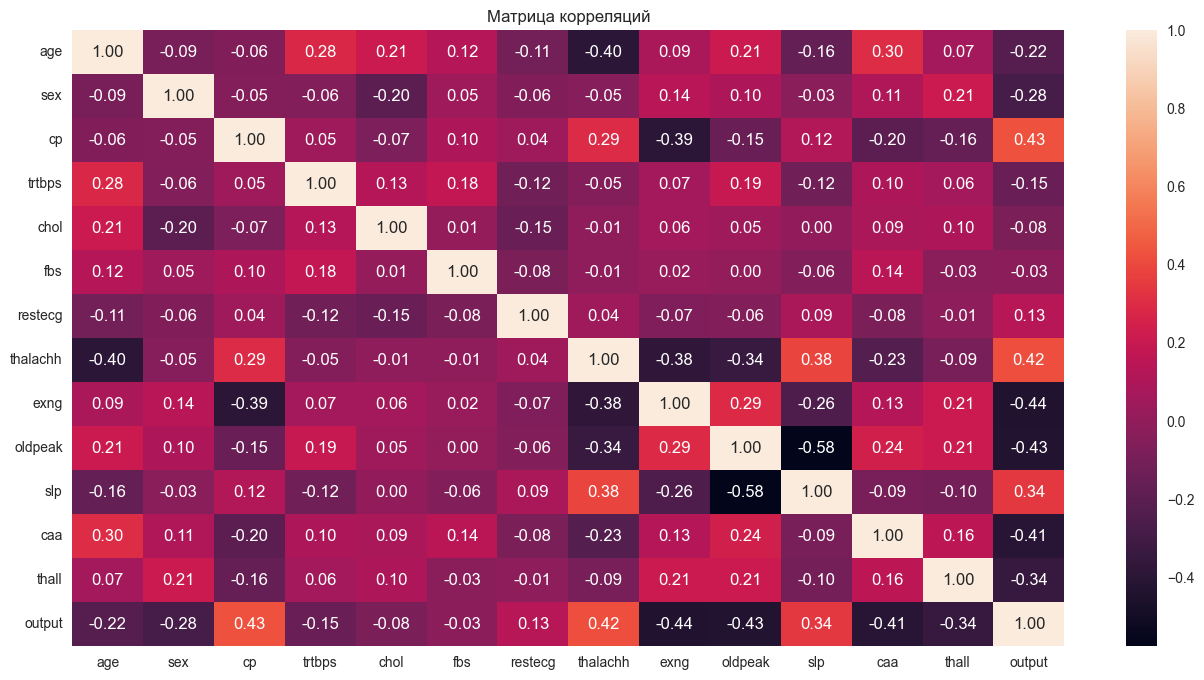

In [15]:
plt.figure(figsize=(16, 8))
plt.title('Матрица корреляций')
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

Максимальная корреляция между столбцами составляет 0.5763

In [16]:
max_corr = data.corr().replace(1.0, 0).abs().max().max()
print(f'{max_corr:.4f}')

0.5763


Выведем распределение категориальных столбцов

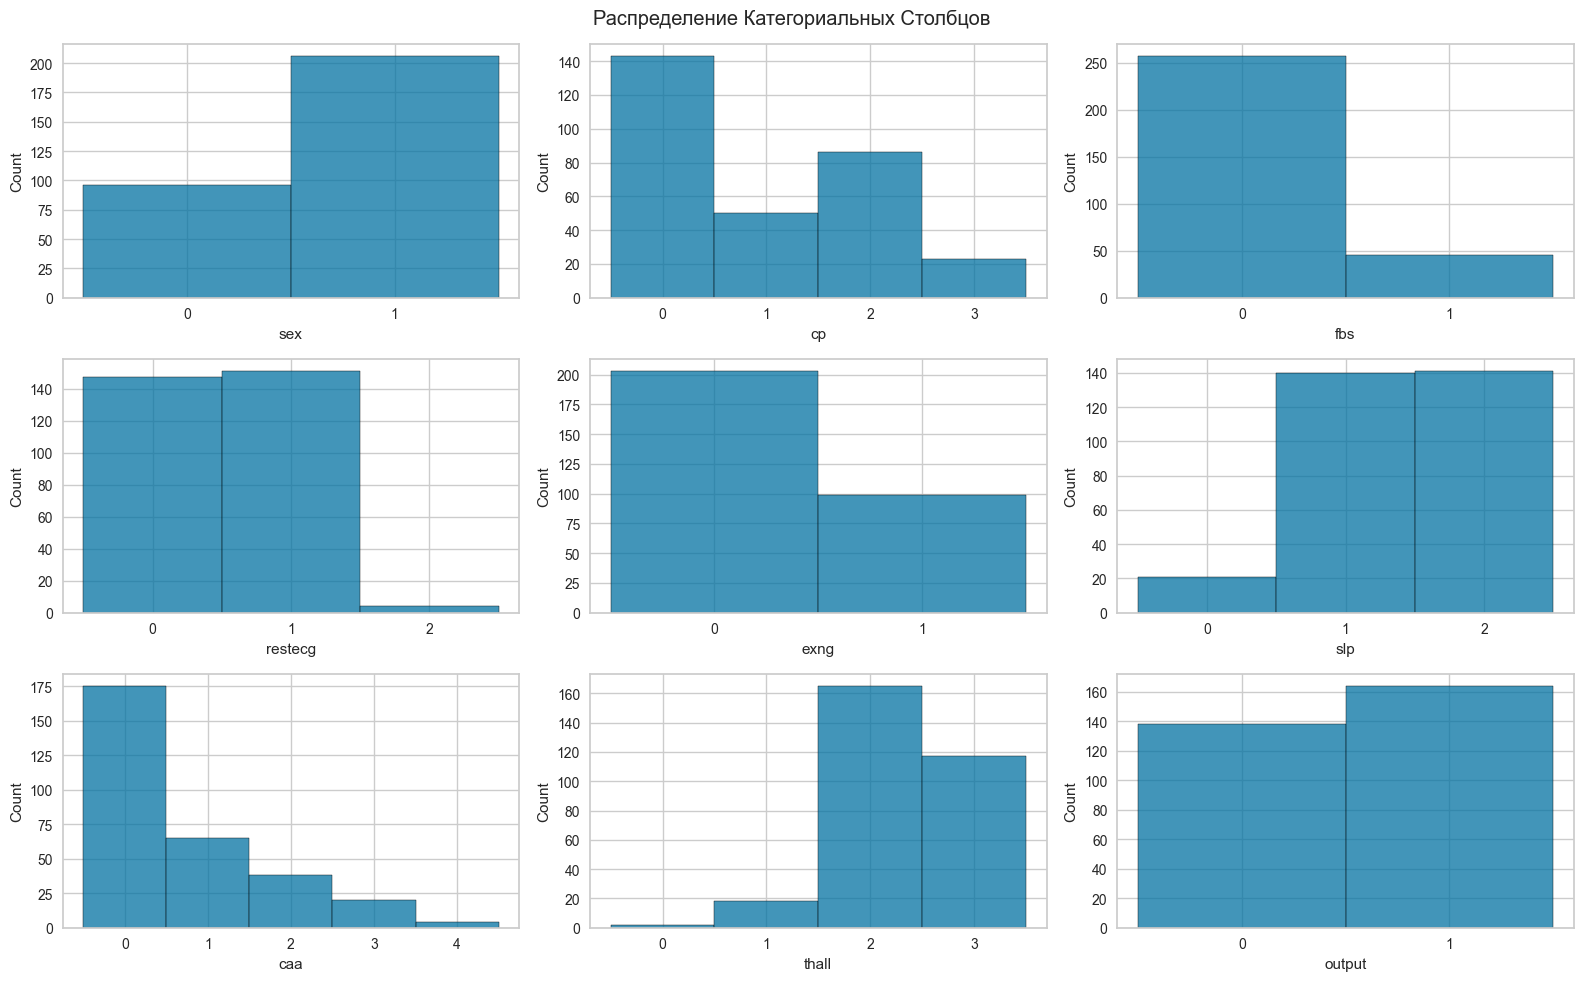

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
fig.suptitle('Распределение Категориальных Столбцов')
for ix, col in enumerate(cat_columns):
    sns.histplot(data, x=col, ax=ax[ix//3][ix%3])
    ax[ix//3][ix%3].set_xticks(np.arange(0, len(np.unique(data[col]))))
fig.tight_layout()
plt.show()

Выведем распределение численных столбцов

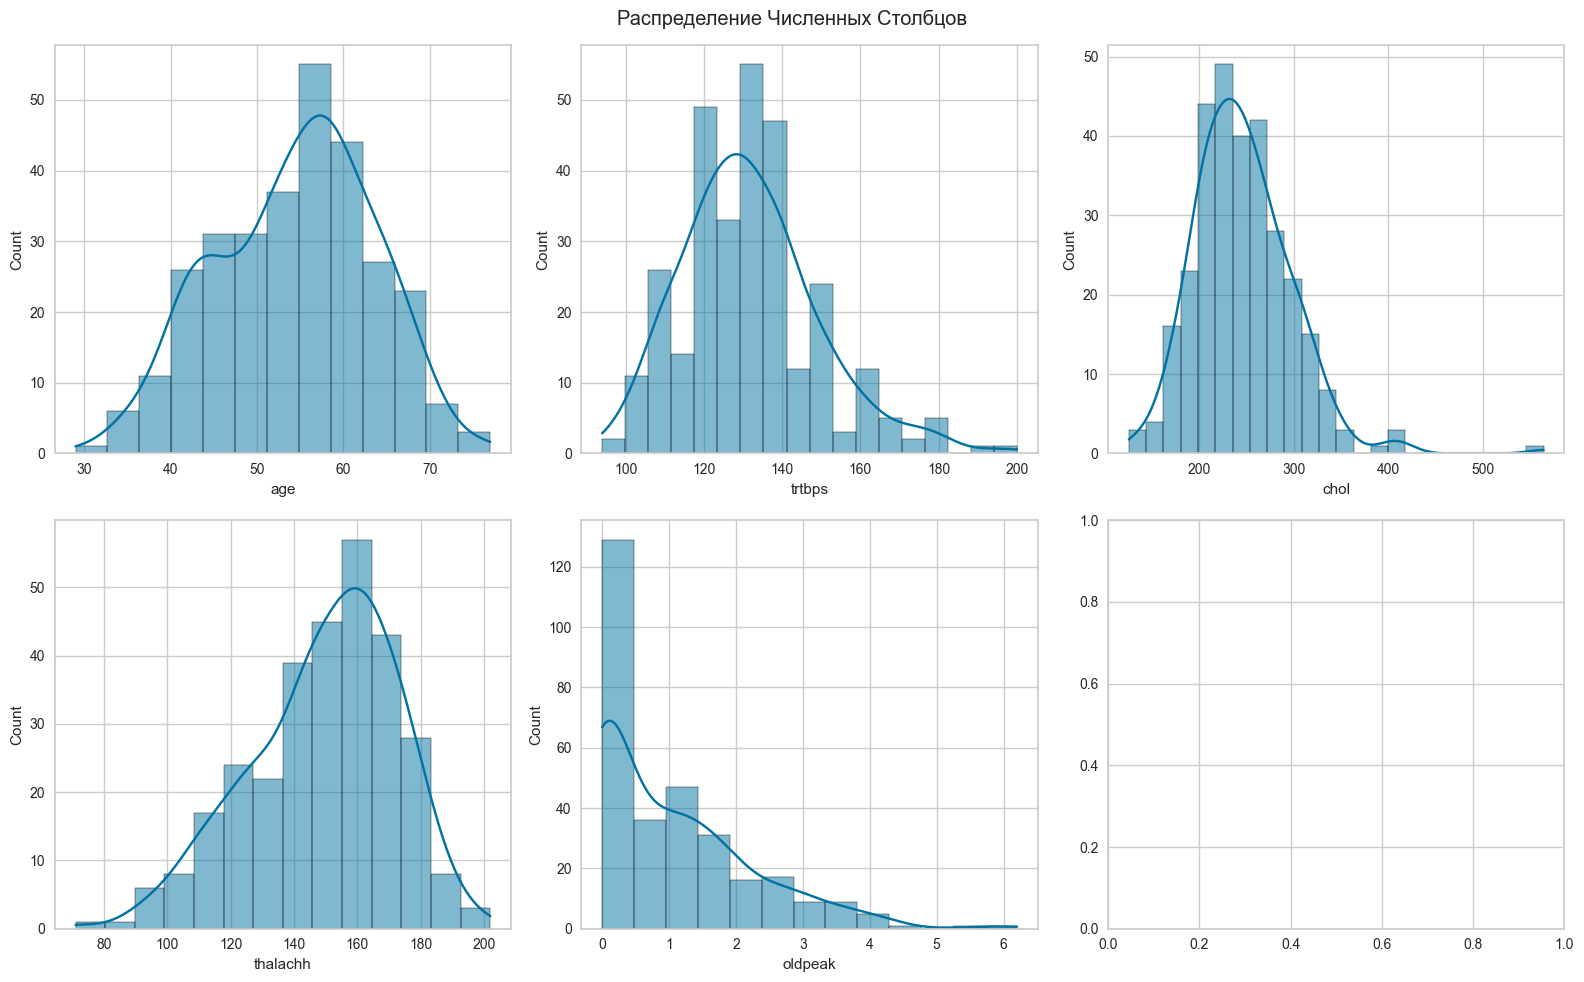

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
fig.suptitle('Распределение Численных Столбцов')
for ix, col in enumerate(num_columns):
    sns.histplot(data, x=col, ax=ax[ix//3][ix%3], kde=True)
fig.tight_layout()
plt.show()

А теперь саспределение величин в зависимости от выживаемости

2024-05-21 10:21:08,580 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-21 10:21:08,585 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-21 10:21:08,613 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-21 10:21:08,622 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-21 10:21:08,644 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates

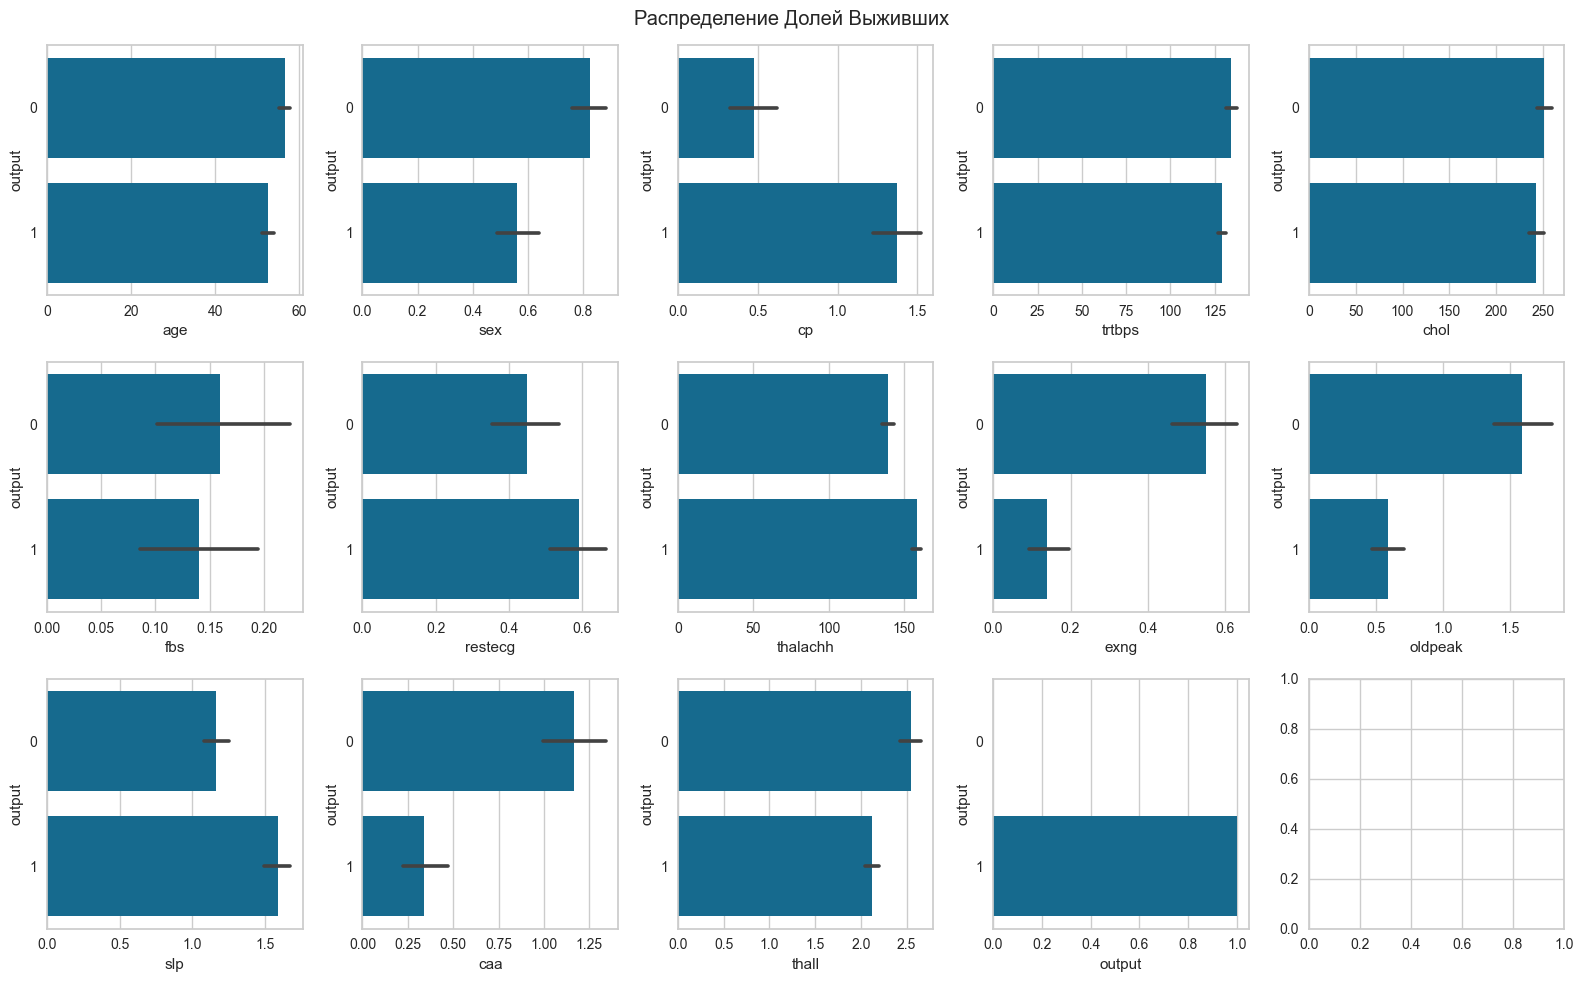

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(16, 10))
fig.suptitle('Распределение Долей Выживших')
for ix, col in enumerate(all_columns):
    sns.barplot(data, x=col, y='output', orient='y', ax=ax[ix//5][ix%5])
fig.tight_layout()
plt.show()

Пропущенных значений у нас нету

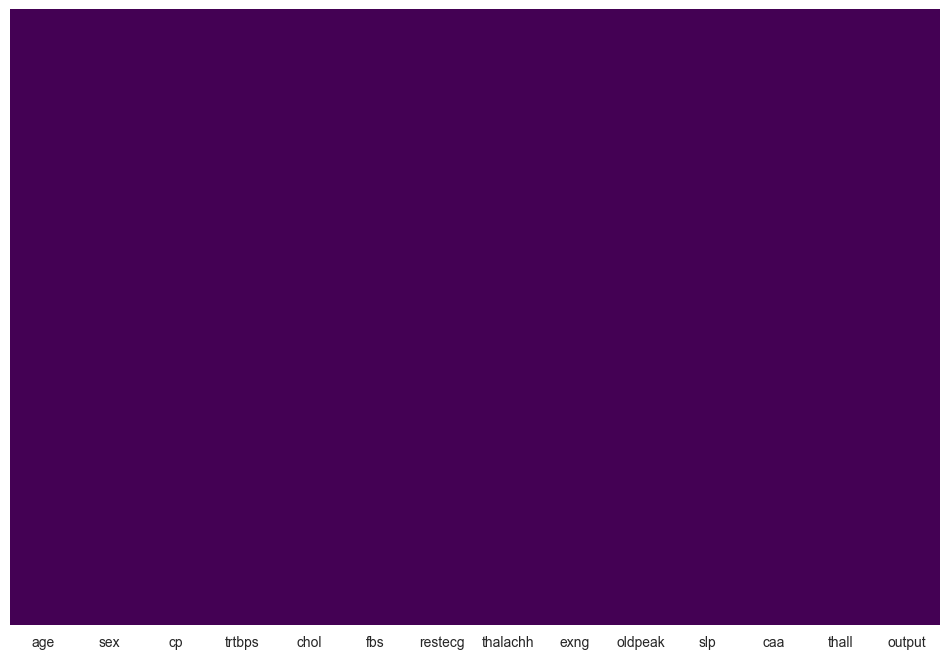

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [21]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       302 non-null    int64   
 1   sex       302 non-null    category
 2   cp        302 non-null    category
 3   trtbps    302 non-null    int64   
 4   chol      302 non-null    int64   
 5   fbs       302 non-null    category
 6   restecg   302 non-null    category
 7   thalachh  302 non-null    int64   
 8   exng      302 non-null    category
 9   oldpeak   302 non-null    float64 
 10  slp       302 non-null    category
 11  caa       302 non-null    category
 12  thall     302 non-null    category
 13  output    302 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 18.2 KB


## <hr>Предварительная обработка данных

In [23]:
data.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


Теперь проебразуем все категориальные переменные при помощи `pd.get_dummies`

In [24]:
data_encoded = pd.get_dummies(data, columns=cat_columns.drop('output'), drop_first=True)
data_encoded.head(3)

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,...,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,1,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,37,130,250,187,3.5,1,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,41,130,204,172,1.4,1,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False


In [25]:
data_encoded.shape

(302, 23)

Обозначим нашу целевую колонку, X и y

In [26]:
target = 'output'
X = data_encoded.drop(columns=target)
y = data_encoded[target]
X.shape, y.shape

((302, 22), (302,))

Поделим данные на 3 выборки: тренировочные, валидационные, тестовые

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)
del X_temp, y_temp
y_train.shape, y_val.shape, y_test.shape

((181,), (60,), (61,))

Оцениим работу модели

In [28]:
model = LogisticRegression(max_iter=10000, random_state=42).fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, f1 = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.7833
f1=0.8169


## <hr>Создание признаков

Задаём список трансформаций и преобразуем данные

In [29]:
transformations = ['1/', 'exp', 'log', 'abs', 'sqrt', '^2', '^3']
afreg = AutoFeatClassifier(transformations=transformations, feateng_cols=list(num_columns), max_gb=16)
afreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


AutoFeatClassifier(feateng_cols=['age', 'trtbps', 'chol', 'thalachh',
                                 'oldpeak'],
                   max_gb=16,
                   transformations=['1/', 'exp', 'log', 'abs', 'sqrt', '^2',
                                    '^3'])

Пока обучим модель на всём что есть, чтобы посмотреть как поменялся результат. Он ухудшилсяб поэтому будем отбирать признаки

In [30]:
model = LogisticRegression(max_iter=100000, random_state=42).fit(afreg.transform(X_train), y_train)
y_pred = model.predict(afreg.transform(X_val))
accuracy, f1 = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.7833
f1=0.8169


Задаём backward feature selection

In [31]:
backward_selector = SequentialFeatureSelector(
    LogisticRegression(max_iter=10000, random_state=42),
    k_features=10,
    forward=False,
    floating=False,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

Обучаем

In [ ]:
backward_selector.fit(afreg.transform(X_train), y_train)

Выводим лучшие признаки

In [33]:
backward_selector_best = backward_selector.k_feature_names_
backward_selector_best

('oldpeak',
 'sex_1',
 'cp_1',
 'cp_2',
 'cp_3',
 'restecg_1',
 'exng_1',
 'slp_1',
 'caa_1',
 'thall_2')

Задаём forward feature selection

In [34]:
forward_selector = SequentialFeatureSelector(
    LogisticRegression(max_iter=10000, random_state=42),
    k_features=10,
    forward=True,
    floating=False,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

Обучаем

In [ ]:
forward_selector.fit(afreg.transform(X_train), y_train)

Выводим лучшие признаки

In [36]:
forward_selector_best = forward_selector.k_feature_names_
forward_selector_best

('age',
 'trtbps',
 'thalachh',
 'cp_1',
 'cp_2',
 'cp_3',
 'caa_2',
 'caa_4',
 'thall_1',
 'thall_2')

берём все уникальные столбцы двух методов

In [37]:
features = list(set(forward_selector_best) | set(backward_selector_best))
features

['caa_4',
 'restecg_1',
 'exng_1',
 'slp_1',
 'cp_1',
 'cp_3',
 'age',
 'thall_2',
 'caa_2',
 'sex_1',
 'thalachh',
 'thall_1',
 'cp_2',
 'trtbps',
 'caa_1',
 'oldpeak']

Выведем графики отбора параметров

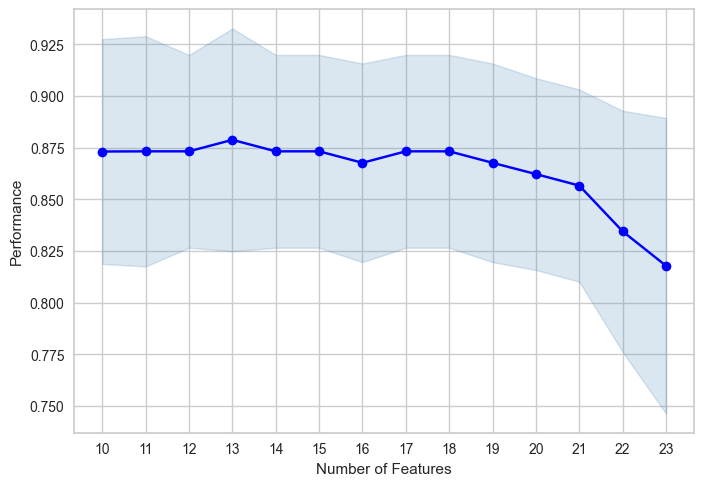

In [38]:
plot_sfs(backward_selector.get_metric_dict(), kind='std_dev')
plt.show()

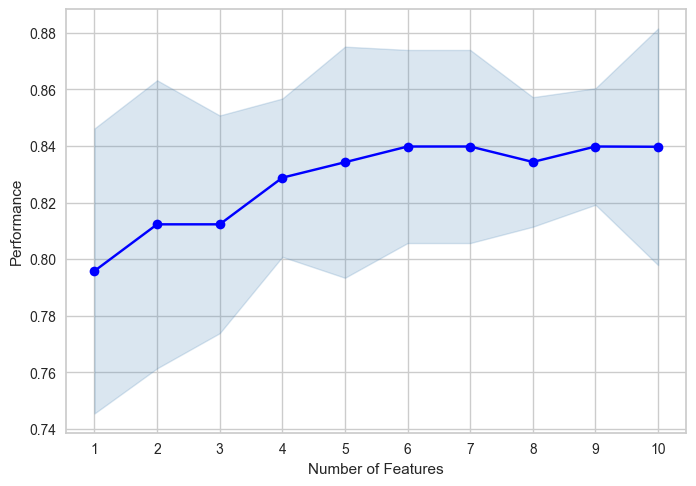

In [39]:
plot_sfs(forward_selector.get_metric_dict(), kind='std_dev')
plt.show()

In [40]:
model = LogisticRegression(max_iter=10000).fit(afreg.transform(X_train)[features], y_train)
y_pred = model.predict(afreg.transform(X_val)[features])
accuracy, f1 = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.7833
f1=0.8219


Ещё раз обучим модель, чтобы посмотреть на результаты с пороговым значением threshold = 0.2

In [41]:
model = LogisticRegression(max_iter=10000).fit(afreg.transform(X_train)[features], y_train)
y_pred = model.predict(afreg.transform(X_val)[features])
y_pred_proba = model.predict_proba(afreg.transform(X_val)[features])

In [42]:
threshold = 0.2
accuracy, f1 = accuracy_score(y_val, y_pred_proba[:, 0] <= threshold), f1_score(y_val, y_pred_proba[:, 0] <= threshold)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.7333
f1=0.7333


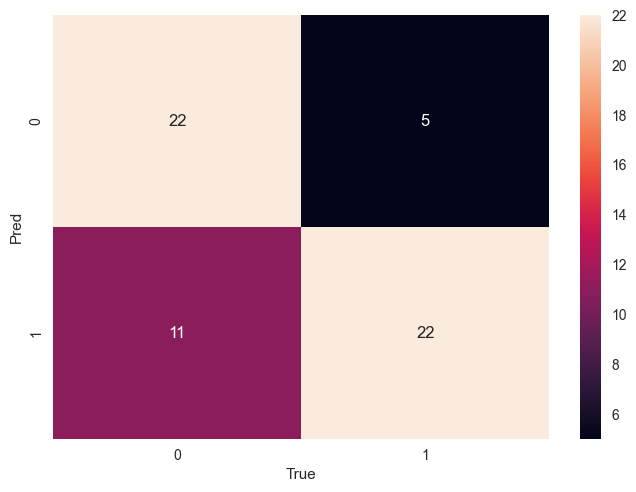

In [43]:
sns.heatmap(confusion_matrix(y_val, y_pred_proba[:, 0] <= threshold), annot=True)
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

In [44]:
print(classification_report(y_val, y_pred_proba[:, 0] <= threshold))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73        27
           1       0.81      0.67      0.73        33

    accuracy                           0.73        60
   macro avg       0.74      0.74      0.73        60
weighted avg       0.75      0.73      0.73        60



В описании датасета кратко написано о том, что при target=1, больше шансов на сердечный приступ, а при target=0 меньше шансов на сердечный приступ. Соответственно, необходимо минимизировать вероятность возникновения ложноотрицательных ошибок, чтобы избежать неверные предасказания.

В качестве метрики можно использовать `accuracy_score`, т.к. перекос в данных совсем небольшой, в дополнение к ней будет использоваться `f1_score`.

## Построение моделей

Определяем модели для обучения

In [45]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Extra Trees Classifier': ExtraTreesClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

Создаем функцию для обучения и оценки моделей

In [46]:
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        results[model_name] = {'accuracy': accuracy, 'f1_score': f1}
        print(f'{model_name}: Accuracy = {accuracy:.4f}, F1 Score = {f1:.4f}')
    return results

Обучаем и оцениваем модели

Logistic Regression: Accuracy = 0.7833, F1 Score = 0.8169
Ridge Classifier: Accuracy = 0.8000, F1 Score = 0.8378
Extra Trees Classifier: Accuracy = 0.7167, F1 Score = 0.7536
K-Nearest Neighbors: Accuracy = 0.6000, F1 Score = 0.6667


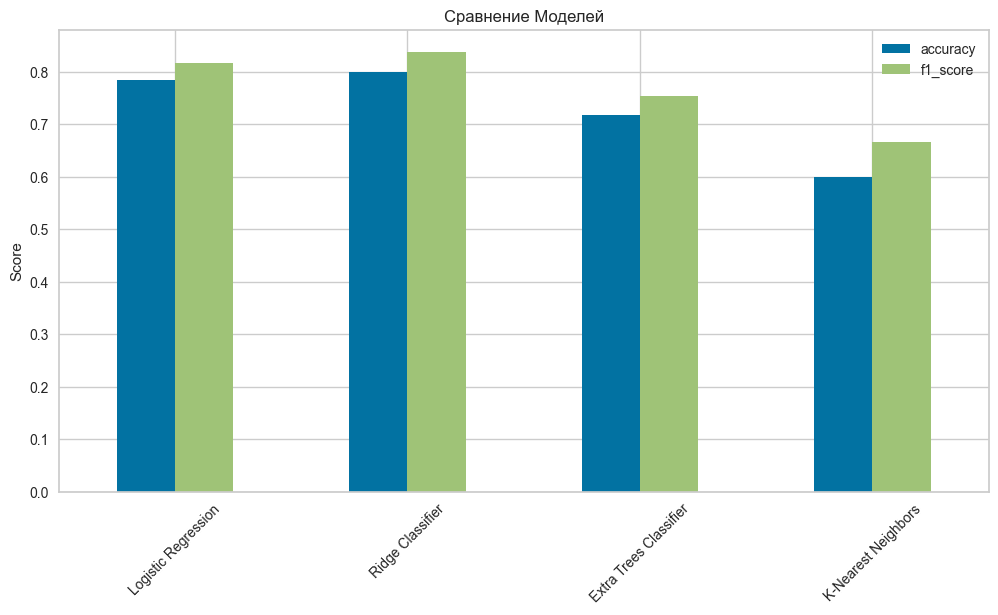

In [47]:
results = train_and_evaluate(models, X_train, y_train, X_val, y_val)
result_df = pd.DataFrame(results).T
result_df.plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение Моделей')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

Лучшей моделью оказалась Ridge Classifier

## Диагностика

In [48]:
criterions = [accuracy_score, f1_score]
criterions_scorer = [make_scorer(i) for i in criterions]

Переобучения нет

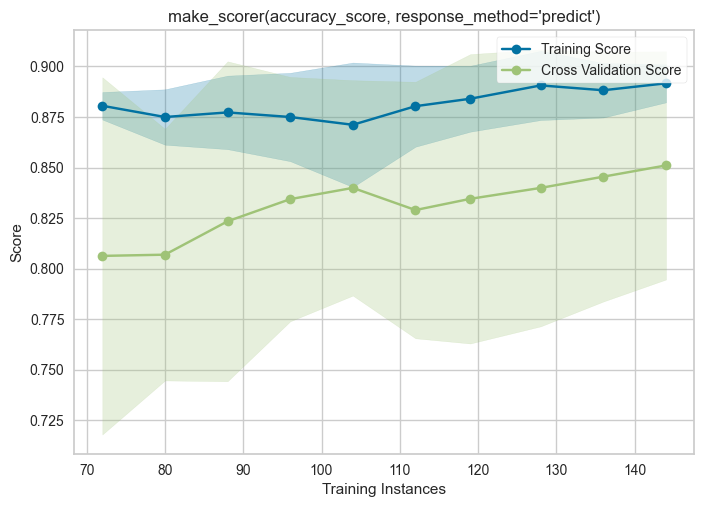

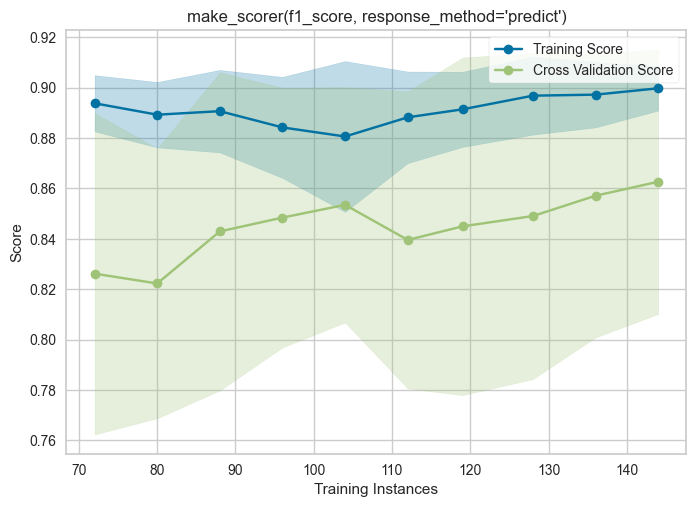

In [49]:
for criterion in criterions_scorer:
    visualizer = LearningCurve(
        RidgeClassifier(),
        scoring=criterion,
        train_sizes=np.linspace(0.5, 1.0, 10),
        title=criterion
    ).fit(X_train, y_train).show()

Также при увеличении регуляризации alpha будем получать результаты хуже

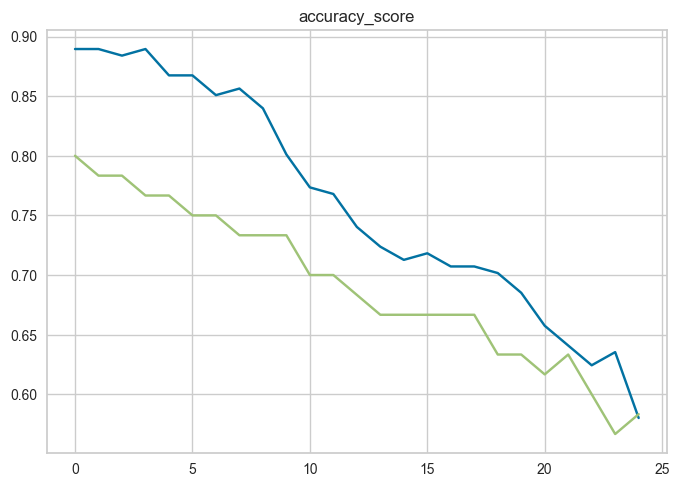

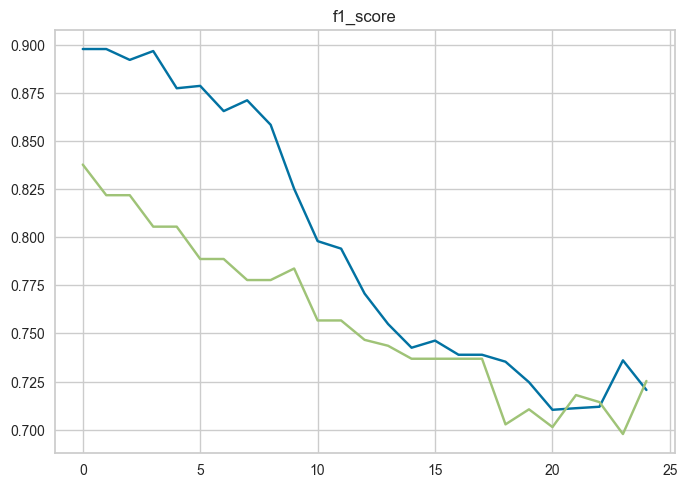

In [50]:
for criterion in criterions:
    trains, tests = [], []
    for i in np.logspace(0, 6, 25):
        ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
        y_pred_train = ridge.predict(X_train)
        y_pred_val = ridge.predict(X_val)
        trains.append(criterion(y_train, y_pred_train))
        tests.append(criterion(y_val, y_pred_val))

    plt.plot(trains)
    plt.plot(tests)
    plt.title(criterion.__name__)
    plt.show()

## Подбор гиперпараметров

Для подбора гиперпараметров используем библиотеку optuna

In [51]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e+2)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    tol = trial.suggest_loguniform('tol', 1e-6, 1e-2)
    
    model = RidgeClassifier(alpha=alpha, solver=solver, tol=tol, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1500)

In [53]:
print('Лучшие гиперпараметры: ', study.best_params)
print('Лучший accuracy score: ', study.best_value)

Лучшие гиперпараметры:  {'alpha': 0.3317977445981329, 'solver': 'lsqr', 'tol': 0.0001499795256469079}
Лучший accuracy score:  0.8


Обучаем модель с лучшими гиперпараметрами и оцениваем ее

In [54]:
best_alpha = study.best_params['alpha']
best_solver = study.best_params['solver']
best_tol = study.best_params['tol']
best_model = RidgeClassifier(alpha=best_alpha, solver=best_solver, tol=best_tol, random_state=42).fit(X_train, y_train)
y_pred = best_model.predict(X_val)
accuracy, f1 = accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.8000
f1=0.8378


Точность предсказаний немного улучшилось

## Ансамбль

Теперь попробуем создать ансамблевую модель из RidgeClassifier, ExtraTreesClassifier и SVC

In [55]:
estimators = [
    ('ridge', RidgeClassifier(random_state=42)),
    ('trees', ExtraTreesClassifier(random_state=42)),
    ('svc', SVC(random_state=42)),
]
stacking_model = StackingClassifier(estimators=estimators, cv=5).fit(X_train, y_train)

In [56]:
y_pred = stacking_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.8000
f1=0.8333


Метрики не улучшились

In [58]:
best_model = RidgeClassifier(alpha=best_alpha, solver=best_solver, tol=best_tol, random_state=42).fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy, f1 = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)
print(f'{accuracy=:.4f}\n{f1=:.4f}')

accuracy=0.8525
f1=0.8696


## Вывод

В данной работе удалось обучить несколько моделей для классификации используя датасет Heart Attack Analysis & Prediction Dataset. Наилучшие результаты были получены с использованием модели Ridge Classifier после оптимизации гиперпараметров.

Метрики моделей зависят от выбранного порога вероятности, который определяет, на каком уровне вероятности модель классифицирует примеры как положительные или отрицательные. Выбор порога критичен для прогнозирование сердечного приступа, поскольку он влияет на баланс между ложноположительными и ложноотрицательными ошибками. Например, можно приоритизировать минимизацию ложноотрицательных ошибок, чтобы снизить вероятность пропуска реальных случаев сердечного приступа.